In [5]:
import pandas as pd

In [6]:
# posts_df
# Data columns (total 9 columns):
# #   Column            Dtype 
# ---  ------            -----
# 0   post_id           object
# 1   thread_id         object
# 2   user_id           int64
# 3   text              object
# 4   reposts_count     int64
# 5   likes_count       int64
# 6   comments_count    int64
# 7   parent_thread_id  object
# 8   timestamp         int64


# unique_users_df
# Data columns (total 7 columns):
# #   Column              Dtype 
# ---  ------              -----
# 0   user_id             int64
# 1   username            object
# 2   friends_count       int64
# 3   followers_count     int64
# 4   bi_followers_count  int64
# 5   user_created_at     int64
# 6   last_activity       int64 
users_df = pd.read_csv("./dataset/weibo_users_df.csv")

# labelled_posts_df
# Data columns (total 11 columns):
# #   Column            Non-Null Count  Dtype 
# ---  ------            --------------  -----
# 0   post_id           4718 non-null   object
# 1   label             4718 non-null   object
# 2   children          4718 non-null   object
# 3   thread_id         4718 non-null   object
# 4   user_id           4718 non-null   int64
# 5   text              4718 non-null   object
# 6   reposts_count     4718 non-null   int64
# 7   likes_count       4718 non-null   int64
# 8   comments_count    4718 non-null   int64
# 9   parent_thread_id  54 non-null     object
# 10  timestamp         4718 non-null   int64 
posts_df = pd.read_csv("./dataset/weibo_posts_merged_df.csv")


In [7]:
import re
import jieba

def clean_text(text):
    # Remove non-Chinese characters (keep Chinese, numbers, and basic punctuation)
    text = re.sub(r"[^\u4e00-\u9fffA-Za-z0-9,，.!?！？]", "", text)
    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

def segment_text(text):
    # Segment text using jieba
    words = jieba.lcut(text)
    # Join words back with spaces (useful for embeddings)
    return ' '.join(words)

# Load a list of Chinese stop words
with open('./dataset/cn_stopwords.txt', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

In [8]:
posts_df['cleaned_text'] = posts_df['text'].fillna("").apply(clean_text)
posts_df['segmented_text'] = posts_df['cleaned_text'].apply(segment_text)
posts_df['final_text'] = posts_df['segmented_text'].apply(remove_stopwords)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/m_/927vvx8x4ysf8rx5tgc4yjmr0000gn/T/jieba.cache
Loading model cost 0.283 seconds.
Prefix dict has been built successfully.


In [9]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Prepare tagged documents
documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(posts_df['final_text'])]
# Train the Doc2Vec model
model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4)

# Add embeddings to the DataFrame
posts_df['text_embeddings'] = posts_df['final_text'].apply(lambda x: model.infer_vector(x.split()))


In [10]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Normalize engagement counts
scaler = MinMaxScaler()
posts_df[['reposts_count', 'likes_count', 'comments_count']] = scaler.fit_transform(
    posts_df[['reposts_count', 'likes_count', 'comments_count']]
)

# Extract time features
posts_df['hour'] = pd.to_datetime(posts_df['timestamp'], unit='s').dt.hour
posts_df['day'] = pd.to_datetime(posts_df['timestamp'], unit='s').dt.day
posts_df['month'] = pd.to_datetime(posts_df['timestamp'], unit='s').dt.month

In [11]:
users_df[['friends_count', 'followers_count', 'bi_followers_count']] = scaler.fit_transform(
    users_df[['friends_count', 'followers_count', 'bi_followers_count']]
)


In [12]:
merged_df = posts_df.merge(users_df, on='user_id', how='left')


In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

X_text = np.stack(merged_df['text_embeddings'].values)
X_user = merged_df[['friends_count', 'followers_count', 'bi_followers_count']].values
y = (merged_df['label']).astype(int).values  # Convert labels to binary

# Split data
X_text_train, X_text_test, X_user_train, X_user_test, y_train, y_test = train_test_split(
    X_text, X_user, y, test_size=0.2, random_state=42
)


In [14]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class CSIDataset(Dataset):
    def __init__(self, text_data, user_data, labels):
        self.text_data = text_data
        self.user_data = user_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.text_data[idx], dtype=torch.float32)
        user = torch.tensor(self.user_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return text, user, label

# Create DataLoaders
train_dataset = CSIDataset(X_text_train, X_user_train, y_train)
test_dataset = CSIDataset(X_text_test, X_user_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [15]:
# change the model class to use other models in model.py
from model import CSIModel

from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

# Hyperparameters
text_embedding_dim = X_text.shape[1]
user_feature_dim = X_user.shape[1]
lstm_hidden_dim = 32
fc_hidden_dim = 16
learning_rate = 0.001
num_epochs = 135

# Initialize the model
model = CSIModel(text_embedding_dim, user_feature_dim, lstm_hidden_dim, fc_hidden_dim)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# # Training loop


training_losses = []
validation_losses = []

for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress", unit="epoch"):
    model.train()
    total_train_loss = 0

    # Training Loop
    for text_batch, user_batch, labels_batch in train_loader:
        text_batch = text_batch.unsqueeze(1)  # Add sequence dimension
        optimizer.zero_grad()

        # Forward pass
        outputs = model(text_batch, user_batch).squeeze()
        loss = criterion(outputs, labels_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Record average training loss
    average_train_loss = total_train_loss / len(train_loader)
    training_losses.append(average_train_loss)

    # Validation Loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for text_batch, user_batch, labels_batch in test_loader:
            text_batch = text_batch.unsqueeze(1)
            outputs = model(text_batch, user_batch).squeeze()
            val_loss = criterion(outputs, labels_batch)
            total_val_loss += val_loss.item()

    # Record average validation loss
    average_val_loss = total_val_loss / len(test_loader)
    validation_losses.append(average_val_loss)

    # Print losses every 50 epochs
    if epoch % 200 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")

Training Progress: 100%|██████████| 135/135 [00:18<00:00,  7.25epoch/s]


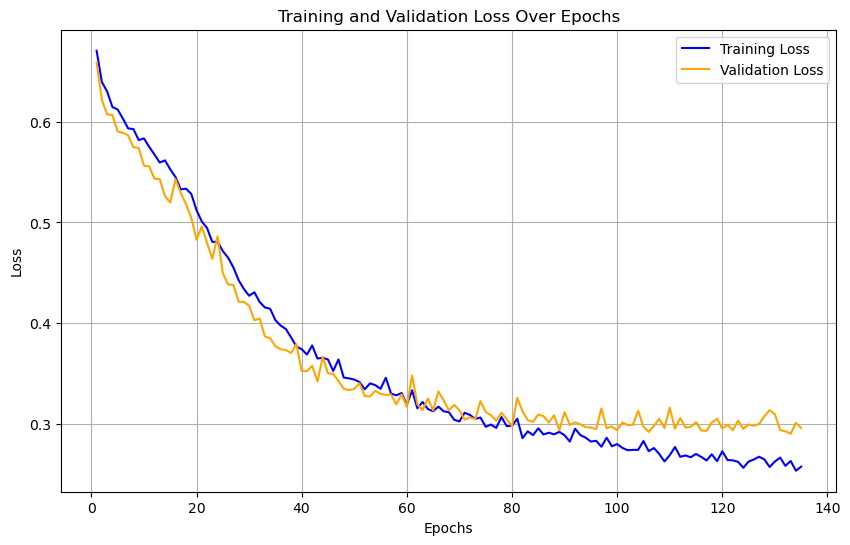

In [23]:
# Plot losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_preds = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for text_batch, user_batch, labels_batch in test_loader:
        outputs = model(text_batch.unsqueeze(1), user_batch).squeeze()
        loss = criterion(outputs, labels_batch.float())  # Compute the batch loss
        test_loss += loss.item() * labels_batch.size(0)  # Accumulate total loss

        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Average loss over the dataset
average_loss = test_loss / len(test_loader.dataset)

# Print metrics
print(f"Test Loss: {average_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Test Loss: 0.2933
Accuracy: 0.8782
Precision: 0.8485
Recall: 0.9130
F1 Score: 0.8796
